In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Import Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

from collections import Counter

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    GlobalAveragePooling1D, BatchNormalization, LeakyReLU, Dropout

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Load dataset

In [3]:
true_data = pd.read_csv('..\Dataset\True.csv', engine='python', encoding='utf-8')
fake_data = pd.read_csv('..\Dataset\Fake.csv', engine='python', encoding='utf-8')

# 2. Data Visualization and Preprocessing

### 2.1. Labeling Data

In [4]:
true_data['label'] = 1
fake_data['label'] = 0

### 2.2. Merging Title and Text Column

In [5]:
data = pd.concat([true_data,fake_data]) \
        .drop(columns=['date'])
data["text"] = data['title'] + ' ' + data['text']
data = data.drop(['title'], axis=1)
data

,text,subject,label
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,1
1,U.S. military to accept transgender recruits o...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,politicsNews,1
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,Middle-east,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,Middle-east,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Middle-east,0
23479,How to Blow $700 Million: Al Jazeera America F...,Middle-east,0


[Text(0, 0, '23481'), Text(0, 0, '21417')]

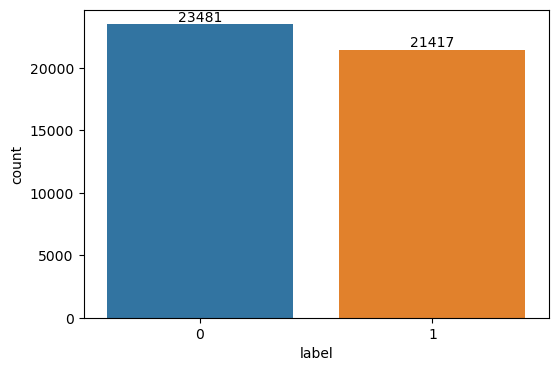

In [6]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'label')
ax.bar_label(ax.containers[0])

### 2.3. Cleaning Text using English Stopword 

In [7]:
stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()


def clean_text(text):
    text = text.lower()
    text = text.replace("[^a-zA-Z#]", " ")
    text = text.replace('http\S+|www.\S+|.com\S+', '')
    text = re.sub("#+","", text)
    text = re.sub("@[\w]*","", text)
    text = re.sub("[^a-z\s]","", text)
    text = re.sub("@[A-Za-z0-9_]+","", text)

    return text

In [8]:
data['clean_text'] = data['text'] \
                    .progress_apply(clean_text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word)>3])) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))
                    # .apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopword)]))

  0%|          | 0/44898 [00:00<?, ?it/s]

  0%|          | 0/44898 [00:00<?, ?it/s]

  0%|          | 0/44898 [00:00<?, ?it/s]

### 2.4. Numbers Text in Text Column

<Axes: xlabel='text_len'>

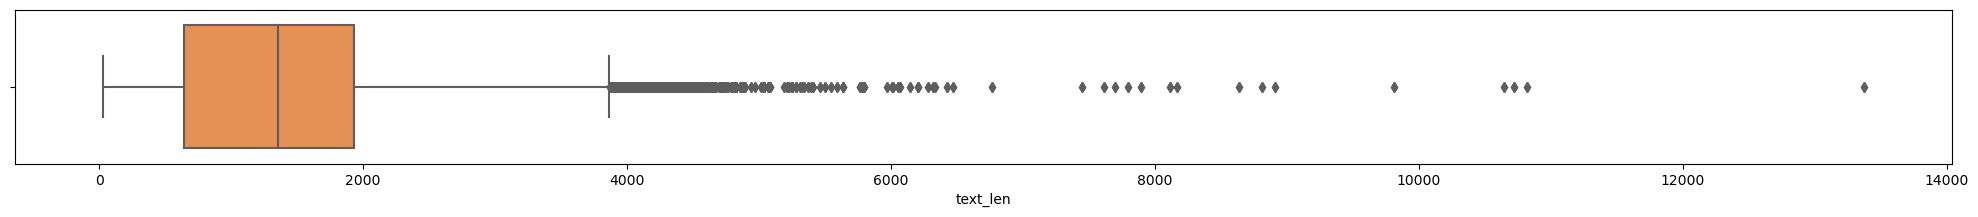

In [10]:
text_len = []

for idx, teks in enumerate(data['clean_text']):
    text_len.append(len(teks))
data['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

<Axes: xlabel='text_len'>

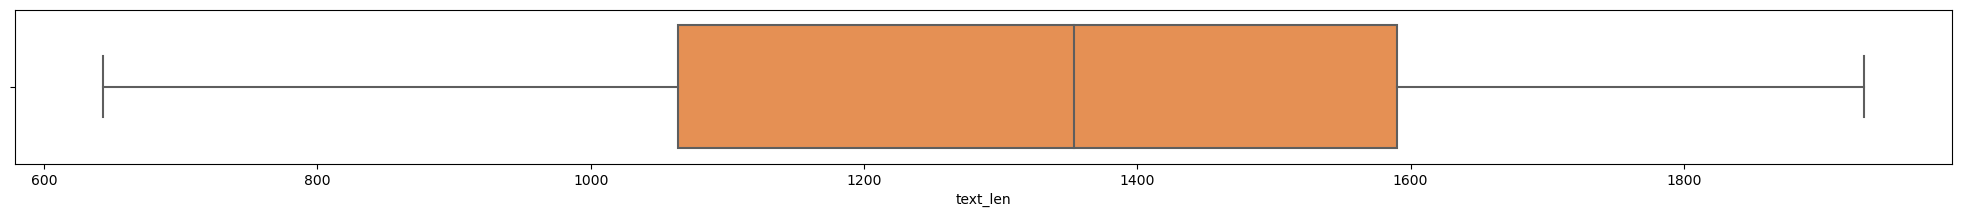

In [11]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(0.75)
IQR = Q3 - Q1

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

[Text(0, 0, '12158'), Text(0, 0, '10287')]

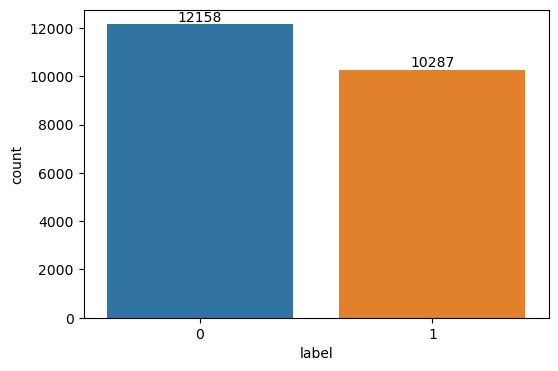

In [12]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'label')
ax.bar_label(ax.containers[0])

# 3. Prepare the data before entering the Model

### 3.1. Splitting the Data into Training and Testing Data

In [13]:
X = data['clean_text']
Y = data['label']
# Y = pd.get_dummies(df_filtered['label'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

### 3.2. Tokenizing Text

In [14]:
vocab_size = 20000
embedding_dim = 1000
max_length = 2000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [16]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print(len(word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np. array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np. array(y_test)

140350


# 4. Model

### 4.1. Model Algorithms

In [17]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GlobalAveragePooling1D())

    model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(128, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())


    # model.add(Dense(2, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GRU(units=32))
    model.add(Dense(units=1))
    return model

def CuDNNGRU_Model():
    sequences = layers.Input(shape=(max_length,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    return model
    


model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()
# model = CuDNNGRU_Model()
# model = RNN_Model()

model.compile(loss='mse', optimizer='adam', metrics=['binary_accuracy'])
# model.compile(loss='mse', optimizer='adam', metrics=['categorical_accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

### 4.2. Training the Model

In [18]:
num_epoch = 10
history = model.fit(training_padded, training_label, 
                    batch_size=64, epochs=num_epoch, 
                    validation_split=0.1)

Epoch 1/10
237/237 [==============================] - 13s 48ms/step - loss: 8.0145 - binary_accuracy: 0.5754 - val_loss: 0.3830 - val_binary_accuracy: 0.5380
Epoch 2/10
237/237 [==============================] - 11s 47ms/step - loss: 0.1111 - binary_accuracy: 0.9293 - val_loss: 0.1978 - val_binary_accuracy: 0.7761
Epoch 3/10
237/237 [==============================] - 11s 47ms/step - loss: 0.0499 - binary_accuracy: 0.9752 - val_loss: 0.0491 - val_binary_accuracy: 0.9840
Epoch 4/10
237/237 [==============================] - 11s 48ms/step - loss: 0.0402 - binary_accuracy: 0.9824 - val_loss: 0.0355 - val_binary_accuracy: 0.9869
Epoch 5/10
237/237 [==============================] - 11s 47ms/step - loss: 0.0415 - binary_accuracy: 0.9826 - val_loss: 0.0964 - val_binary_accuracy: 0.8967
Epoch 6/10
237/237 [==============================] - 11s 47ms/step - loss: 0.0387 - binary_accuracy: 0.9867 - val_loss: 0.0306 - val_binary_accuracy: 0.9840
Epoch 7/10
237/237 [==============================] 

# 5. Analysis after Training of Model

### 5.1. Showing Model Accuracy and Loss

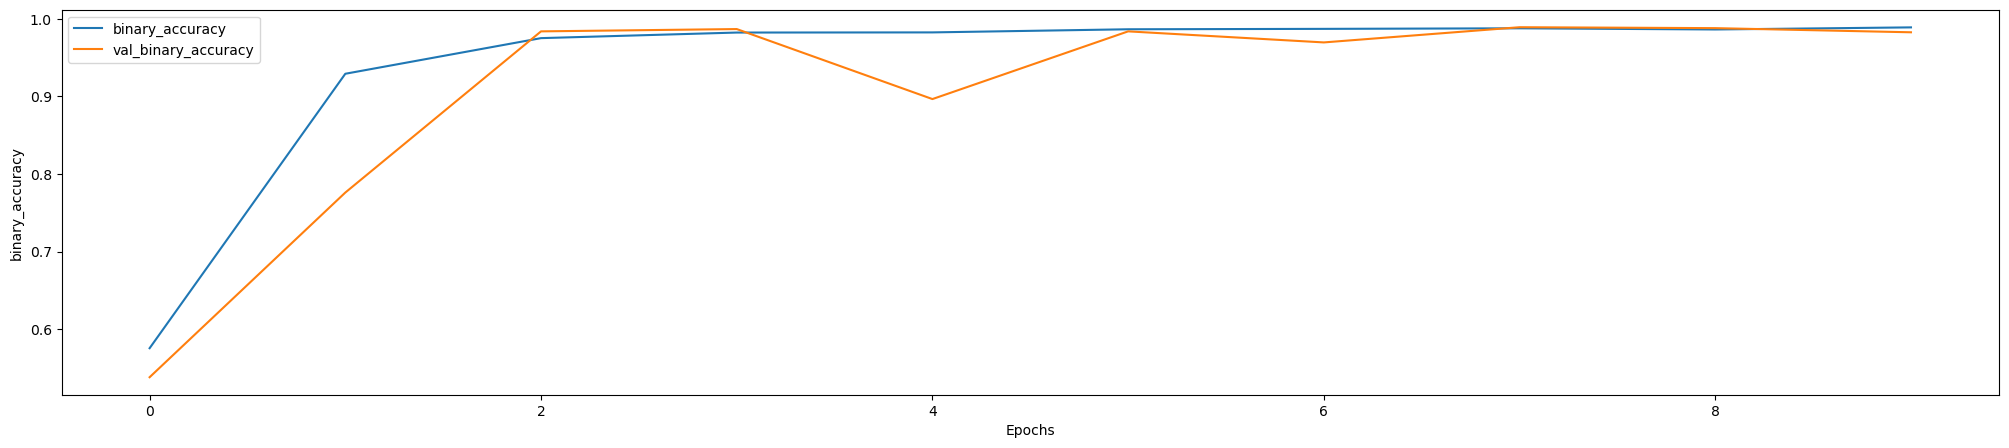

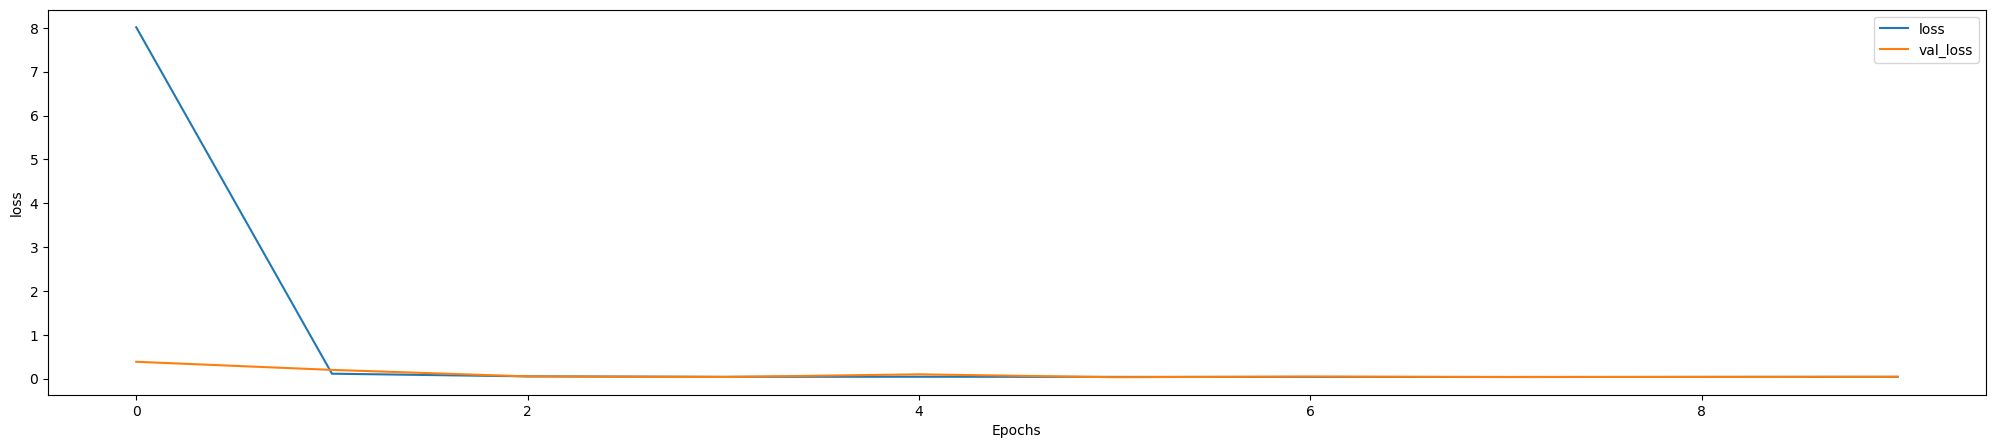

In [19]:
def plot_graphs(history, string):
    plt.subplots(figsize=(25, 5))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "binary_accuracy")
plot_graphs(history, "loss")

### 4.2. Confusion Matrix

176/176 [==============================] - 1s 6ms/step


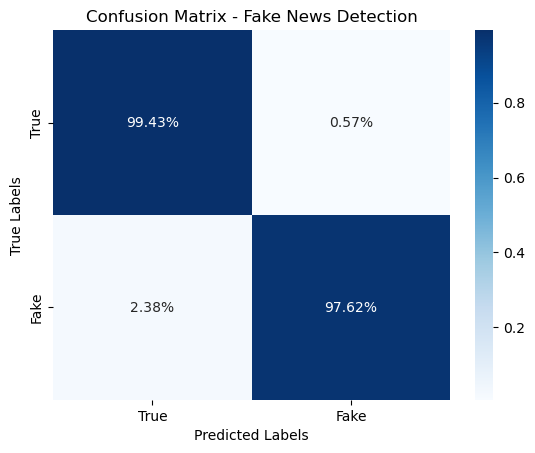

In [20]:
labels = ['True', 'Fake']

y_pred = np.rint(model.predict(testing_padded))
# Build confusion matrix
con_mat = confusion_matrix(y_test,y_pred)

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()